In [1]:
# Brachistochrone solver: 04/02/2024

import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Constants
total_y_drop = 1.0
n_segments = 1000
g = 9.81
dx = 5.0 / n_segments

device = torch.device("cuda") # or cpu


In [ ]:

# Initialize dy
dy = torch.rand(n_segments, requires_grad=True, device=device)
dy.data = dy.data * total_y_drop / dy.data.sum()

# Optimizer setup
optimizer = optim.AdamW([dy], lr=0.0001)  # Adjust learning rate as necessary


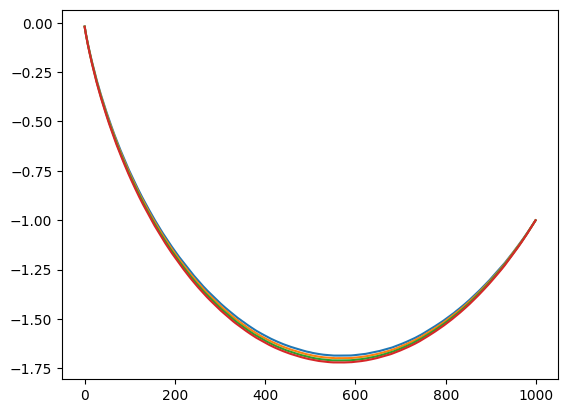

In [9]:
iterations = int(100)

# Optimization loop
for i in range(iterations):
    optimizer.zero_grad()
    constraint = dy.sum() - total_y_drop
    distances = torch.sqrt(dx**(2) + dy**(2))

    cumsum_y = torch.cumsum(dy, dim=0)
    shifted_cumsum_y = torch.cat((torch.zeros(1, device=dy.device), cumsum_y[:-1]))
    y_av = 0.5*(cumsum_y + shifted_cumsum_y)
    
    # velocity related directly to height by mgh = 0.5mv**2
    velocity = torch.sqrt(2 * g * y_av)

    time = torch.sum(distances / velocity)
    loss = time + 100 * constraint**2 # large loss on constraint. 
    loss.backward()
    optimizer.step()

    if  i%(iterations//3) == 0 :
        print(i)
        #plt.plot(range(n_segments), -cumsum_y.detach().numpy())


In [ ]:
plt.plot(range(n_segments), -cumsum_y.detach().numpy())

In [ ]:
# results:

# 10 iteration:

# 1e6 segments
# gpu 0.4s
# cpu 43s, 19min cpu time

# 1e5 
# gpu 0.04
# cpu 43s

# 1e4
# gpu 24ms
# cpu 3.0s

# 1e3
# cpu 8ms
# gpu 28ms



# now 1e4 but increase iterations
# 100, 1000, 10,000, 100,000
# gpu 200ms, 1.74s, 11.7s, 85s
# cpu 31.5s, 5 min 18s


# now 1e3 but increase iterations
# 100, 1000, 10,000, 100,000
# gpu x,x,x, 1min 29
# cpu 73ms, 578ms, 5s, 50s

# conclusion:
# increasing iterations makes no differnce to cpu vs GPU
# increasing segments increases GPU cores utilsation and quickly makes GPU faster than CPU (from 10,00 onwards).
# more parameters to solve for may favour GPU depending on if they can be calculated in parallel with any others with the same operatons.